In [1]:
setwd("~/Desktop/9890")
library(glmnet)
library(ggplot2)
library(gridExtra)
library(dplyr)
library(MASS)
library(randomForest)
library(tidyverse)
library(grid)
library(viridis)
rm(list = ls())    #delete objects
cat("\014")


Loading required package: Matrix

Loaded glmnet 3.0-2



Attaching package: ‘dplyr’


The following object is masked from ‘package:gridExtra’:

    combine


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select


randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:dplyr’:

    combine


The following object is masked from ‘package:gridExtra’:

    combine


The following object is masked from ‘package:ggplot2’:

    margin


── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──

✔ tibble  2.1.3     ✔ purrr   0.3.2
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0

── Conflicts ────────────────────────────────────────── tidyver

In [2]:
# read data
c17 <- read.csv("COMBO17.csv", header=T)
head(c17)


,Nr,Rmag,e.Rmag,ApDRmag,mumax,Mcz,e.Mcz,MCzml,chi2red,UjMAG,⋯,UFS,e.UFS,BFS,e.BFS,VFD,e.VFD,RFS,e.RFS,IFD,e.IFD
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,6,24.995,0.097,0.935,24.214,0.832,0.036,1.400,0.64,-17.67,⋯,0.01870,0.00239,0.01630,0.00129,1.73e-02,0.00141,0.01650,0.000434,0.02470,0.00483
2,9,25.013,0.181,-0.135,25.303,0.927,0.122,0.864,0.41,-18.28,⋯,0.00706,0.00238,0.00420,0.00115,3.93e-03,0.00182,0.00723,0.000500,0.00973,0.00460
3,16,24.246,0.054,0.821,23.511,1.202,0.037,1.217,0.92,-19.75,⋯,0.01260,0.00184,0.01830,0.00115,1.88e-02,0.00167,0.02880,0.000655,0.05700,0.00465
4,21,25.203,0.128,0.639,24.948,0.912,0.177,0.776,0.39,-17.83,⋯,0.01410,0.00186,0.01180,0.00110,9.67e-03,0.00204,0.01050,0.000416,0.01340,0.00330
5,26,25.504,0.112,-1.588,24.934,0.848,0.067,1.330,1.45,-17.69,⋯,0.00514,0.00170,0.00102,0.00127,3.85e-05,0.00160,0.00139,0.000499,0.00590,0.00444
6,29,23.740,0.056,-1.636,24.609,0.882,0.183,0.877,0.52,-19.22,⋯,0.00292,0.00198,0.00329,0.00104,3.55e-03,0.00130,0.00474,0.000489,0.00356,0.00446


In [3]:
str(c17)

'data.frame':	3462 obs. of  65 variables:
 $ Nr      : int  6 9 16 21 26 29 45 49 50 51 ...
 $ Rmag    : num  25 25 24.2 25.2 25.5 ...
 $ e.Rmag  : num  0.097 0.181 0.054 0.128 0.112 0.056 0.257 0.217 0.098 0.097 ...
 $ ApDRmag : num  0.935 -0.135 0.821 0.639 -1.588 ...
 $ mumax   : num  24.2 25.3 23.5 24.9 24.9 ...
 $ Mcz     : num  0.832 0.927 1.202 0.912 0.848 ...
 $ e.Mcz   : num  0.036 0.122 0.037 0.177 0.067 0.183 0.174 0.147 0.052 0.057 ...
 $ MCzml   : num  1.4 0.864 1.217 0.776 1.33 ...
 $ chi2red : num  0.64 0.41 0.92 0.39 1.45 0.52 1.31 1.84 1.03 0.55 ...
 $ UjMAG   : num  -17.7 -18.3 -19.8 -17.8 -17.7 ...
 $ e.UjMAG : num  0.14 0.22 0.14 0.17 0.42 0.16 0.3 0.44 0.15 0.16 ...
 $ BjMAG   : num  -17.5 17.9 -19.9 -17.4 -18.4 ...
 $ e.BjMAG : num  0.25 0.55 0.14 0.31 0.83 1.37 1.94 1.81 0.15 0.19 ...
 $ VjMAG   : num  -17.8 -18.2 -20.4 -17.7 -19.4 ...
 $ e.VjMAG : num  0.25 0.55 0.14 0.31 0.83 1.37 1.94 1.81 0.32 0.14 ...
 $ usMAG   : num  -17.8 -18.4 -19.9 -18 -17.8 ...
 $ e.us

In [4]:
# clean data
c17[,"e.W420FE"] <- as.numeric(gsub(" ", "", gsub("E", "e", c17[,"e.W420FE"])))


In [5]:
# remove uneccessary columns
c17 <- c17[,-c(1, 7, 8, 9)]


In [6]:
# remove NA values
c17 <- na.omit(c17)
rownames(c17) <- c(seq(1, nrow(c17), 1))

In [7]:
# change order of columns so that target variable will be the first column
c17 <- c17[,c(5,1,2,3,4,6:ncol(c17))]


In [8]:
# standardize all predictor columns
# c17[,-1] <- scale(c17[,-1])
for (i in 2:ncol(c17)) {
    c17[,i] <- c17[,i]/sd(c17[,i])
}
head(c17)

,Mcz,Rmag,e.Rmag,ApDRmag,mumax,UjMAG,e.UjMAG,BjMAG,e.BjMAG,VjMAG,⋯,UFS,e.UFS,BFS,e.BFS,VFD,e.VFD,RFS,e.RFS,IFD,e.IFD
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.832,17.45794,1.1753331,2.0692635,23.81790,-8.994743,0.8319853,-8.269375,0.2040082,-8.492223,⋯,0.7355682,7.138899,0.25314860,3.747996,0.1448624289,2.230498,0.100246498,2.176840,0.13116175,3.240834
2,0.927,17.47051,2.1931473,-0.2987707,24.88909,-9.305258,1.3074055,8.420242,0.4488179,-8.702616,⋯,0.2777065,7.109029,0.06522847,3.341237,0.0329080547,2.879083,0.043926193,2.507880,0.05166817,3.086508
3,1.202,16.93480,0.6543091,1.8169683,23.12640,-10.053547,0.8319853,-9.386731,0.1142446,-9.759362,⋯,0.4956235,5.496056,0.28420978,3.341237,0.1574227551,2.641796,0.174975706,3.285323,0.30268097,3.120057
4,0.912,17.60322,1.5509550,1.4141812,24.53990,-9.076189,1.0102679,-8.198657,0.2529701,-8.449188,⋯,0.5546263,5.555796,0.18326095,3.195966,0.0809722363,3.227104,0.063793226,2.086556,0.07115658,2.214234
5,0.848,17.81346,1.3570856,-3.5144283,24.52613,-9.004924,2.4959559,-8.674829,0.6773071,-9.262070,⋯,0.2021829,5.077878,0.01584120,3.689888,0.0003223817,2.531062,0.008445008,2.502864,0.03133014,2.979151
6,0.882,16.58138,0.6785428,-3.6206579,24.20644,-9.783756,0.9508403,-8.538106,1.1179647,-8.941699,⋯,0.1148588,5.914234,0.05109564,3.021640,0.0297261054,2.056488,0.028798085,2.452706,0.01890429,2.992571


In [9]:
# define dimension
p                  <-  dim(c17)[2]-1
n                  <-  dim(c17)[1]
train.rate         <- 0.8
# number of iteration and K folds
iterations         <- 100
K                  <- 10

# train and test R2
train.r2           <-  matrix(0, nrow = iterations, ncol = 4)
colnames(train.r2) <-  c("Lasso", "Elastic", "Ridge", "RF")
test.r2            <-  matrix(0, nrow = iterations, ncol = 4)
colnames(test.r2)  <-  c("Lasso", "Elastic", "Ridge", "RF")

# Matrix of 100 train coefficients - NOT USE
matrix.coef        <- list(lasso=matrix(0, nrow = iterations, ncol = p+1),
                           elastic=matrix(0, nrow = iterations, ncol = p+1),
                           ridge=matrix(0, nrow = iterations, ncol = p+1))
lasso.coef         <-  matrix(0, nrow = iterations, ncol = p+1)
el.coef            <-  matrix(0, nrow = iterations, ncol = p+1)
rid.coef           <-  matrix(0, nrow = iterations, ncol = p+1)

# RF
rf.importance      <- matrix(0, nrow = iterations, ncol = p)

# time for cv and model fit
time.cv            <-  matrix(0, nrow = iterations, ncol = 3)
colnames(time.cv)  <-  c("Lasso", "Elastic", "Ridge")
time.fit           <-  matrix(0, nrow = iterations, ncol = 4)
colnames(time.fit) <-  c("Lasso", "Elastic", "Ridge", "RF")

# mean cross validation error - NOT USE
cv.error           <- matrix(0, nrow = iterations, ncol = 3)

# train and test risiduals - NOT USE
train.resid        <-  matrix(0, nrow = floor(n*train.rate), ncol = 3)
colnames(train.resid)  <-  c("Lasso", "Elastic", "Ridge")
test.resid         <-  matrix(0, nrow = n-floor(n*train.rate), ncol = 3)
colnames(test.resid)  <-  c("Lasso", "Elastic", "Ridge")

In [10]:
# shuffle data
set.seed(3)
samp.ind    <- sample(n, n)
X           <- as.matrix(c17[samp.ind, -1])
y           <- c17[samp.ind,1]
train.rate  <- 0.8

In [ ]:
#   Rsq.test.ls[m]   =     1-mean((y.test - y.test.hat)^2)/mean((y.test - mean(y.test))^2)
#   Rsq.train.ls[m]  =     1-mean((y.train - y.train.hat)^2)/mean((y.train - mean(y.train))^2) 

In [11]:
for(m in 1:iterations){
  
  cat(sprintf("iteration = %3.f \n", m))
    
  train  <-  sample(n, n*train.rate)
  
  ############ lasso regression
  # begin cross validate
  start.time  <- proc.time()
  cv.lasso  <-  cv.glmnet(X[train,], y[train],
                          alpha = 1, family = "gaussian",
                          intercept = T)
  end.time  <-  proc.time() - start.time
  time.cv[m,1]   <-  end.time["elapsed"]
  cv.error[m,1] = min(cv.lasso$cvm)
  # begin model fit
  start.time  <- proc.time()
  lasso.fit = glmnet(X[train,], y[train],
                     alpha = 1, family = "gaussian",
                     intercept = T,
                     lambda = cv.lasso$lambda.min,
                     standardize = F)
  end.time  <-  proc.time() - start.time
  time.fit[m,1]  = end.time["elapsed"]
  # calculate trainr2, testr2, train residuals and testresduals
  lasso.coef[m,] = coef(lasso.fit)[,1]
  train.pred = as.vector(predict(lasso.fit, newx = X[train,], type ="response"))
  lasso.train.resid = y[train] - train.pred
  train.r2[m,1] = 1 - mean((y[train] - train.pred)^2)/mean((y[train]-mean(y[train]))^2)
  
  test.pred = as.vector(predict(lasso.fit, newx = X[-train,], type="response"))
  lasso.test.resid = y[-train] - test.pred
  test.r2[m,1] = 1 - mean((y[-train] - test.pred)^2)/mean((y[-train]-mean(y[-train]))^2)

  ############# elastic net
  # begin cross-validation
  start.time  <- proc.time()
  cv.el = cv.glmnet(X[train,], y[train],
                    alpha = 0.5, family = "gaussian",
                    intercept = T)
  end.time  <-  proc.time() - start.time
  time.cv[m,2]  = end.time["elapsed"]
  cv.error[m,2] = min(cv.el$cvm)
  # begin model fit
  start.time  <- proc.time()
  el.fit = glmnet(X[train,], y[train],
                  alpha = 0.5, family = "gaussian",
                  intercept = T,
                  lambda = cv.el$lambda.min,
                  standardize = F)
  end.time  <-  proc.time() - start.time
  time.fit[m,2]  = end.time["elapsed"]
  # calculate trainr2, testr2, train residuals and testresduals
  el.coef[m,] = coef(el.fit)[,1]
  train.pred = as.vector(predict(el.fit, newx = X[train,], type ="response"))
  el.train.resid = y[train] - train.pred
  train.r2[m,2] = 1 - mean((y[train] - train.pred)^2)/mean((y[train]-mean(y[train]))^2)

  test.pred = as.vector(predict(el.fit, newx = X[-train,], type="response"))
  el.test.resid = y[-train] - test.pred
  test.r2[m,2] = 1 - mean((y[-train] - test.pred)^2)/mean((y[-train]-mean(y[-train]))^2)
    
  ############## ridge 
  # begin cross-validation
  start.time  <- proc.time()
  cv.rid = cv.glmnet(X[train,], y[train],
                     alpha = 0, family = "gaussian",
                     intercept = T)
  end.time  <-  proc.time() - start.time
  time.cv[m,3]  = end.time["elapsed"]
  cv.error[m,3] = min(cv.rid$cvm)
  # begin model fit
  start.time  <- proc.time()
  rid.fit = glmnet(X[train,], y[train],
                   alpha = 0, family = "gaussian", 
                   intercept = T, lambda = cv.rid$lambda.min,
                   standardize = F)
  end.time  <-  proc.time() - start.time
  time.fit[m,3]  = end.time["elapsed"]
  # calculate trainr2, testr2, train residuals and testresduals
  rid.coef[m,] = coef(rid.fit)[,1]
  train.pred = as.vector(predict(rid.fit, newx = X[train,], type = "response"))
  rid.train.resid = y[train] - train.pred
  train.r2[m,3] = 1 - mean((y[train] - train.pred)^2)/mean((y[train]-mean(y[train]))^2)

  test.pred = as.vector(predict(rid.fit, newx = X[-train,], type = "response"))
  rid.test.resid = y[-train] - test.pred
  test.r2[m,3] = 1 - mean((y[-train] - test.pred)^2)/mean((y[-train]-mean(y[-train]))^2)

  ############### random forest 
  # begin model fit
  start.time  <- proc.time()
  rf = randomForest(X[train,], y[train], mtry = sqrt(p), importance = T)
  end.time  <-  proc.time() - start.time
  time.fit[m,4]  = end.time["elapsed"]
  # calculate trainr2, testr2, train residuals and testresduals
  train.pred = predict(rf, newdata = X[train,])
  rf.train.resid = y[train] - train.pred
  train.r2[m,4] = 1 - mean((y[train] - train.pred)^2)/mean((y[train]-mean(y[train]))^2)
    
  test.pred = predict(rf, newdata = X[-train,])
  rf.test.resid = y[-train] - test.pred
  test.r2[m,4] = 1 - mean((y[-train] - test.pred)^2)/mean((y[-train]-mean(y[-train]))^2)
  rf.importance[m,]  <- rf$importance[,1] 
}


iteration =   1 
iteration =   2 
iteration =   3 
iteration =   4 
iteration =   5 
iteration =   6 
iteration =   7 
iteration =   8 
iteration =   9 
iteration =  10 
iteration =  11 
iteration =  12 
iteration =  13 
iteration =  14 
iteration =  15 
iteration =  16 
iteration =  17 
iteration =  18 
iteration =  19 
iteration =  20 
iteration =  21 
iteration =  22 
iteration =  23 
iteration =  24 
iteration =  25 
iteration =  26 
iteration =  27 
iteration =  28 
iteration =  29 
iteration =  30 
iteration =  31 
iteration =  32 
iteration =  33 
iteration =  34 
iteration =  35 
iteration =  36 
iteration =  37 
iteration =  38 
iteration =  39 
iteration =  40 
iteration =  41 
iteration =  42 
iteration =  43 
iteration =  44 
iteration =  45 
iteration =  46 
iteration =  47 
iteration =  48 
iteration =  49 
iteration =  50 
iteration =  51 
iteration =  52 
iteration =  53 
iteration =  54 
iteration =  55 
iteration =  56 
iteration =  57 
iteration =  58 
iteration =  5

In [14]:
## NOT USE - WON'T BE ABLE TO GET THE CV CURVE
# alphas  <- list(1, 0.5, 0)

# for(m in 1:iterations) {
#     cat(sprintf("iteration = ", m, "\n"))
#     train  <-  sample(n, n*train.rate)
    
#     for(i in seq_along(alphas)) {
        
#         # lasso/elastic/ridge regression
#         start.time     <- proc.time()
#         cv             <-  cv.glmnet(X[train,], y[train], alpha = alphas[[i]], family = "gaussian", intercept = T)
#         end.time       <-  proc.time() - start.time
#         time.cv[m,i]   <-  end.time["elapsed"]

#         cv.error[m,i]  <-  min(cv$cvm)
#         #bestlam = cv$lambda.min

#         # record lasso fit time
#         start.time     <- proc.time()
#         mod            <-  glmnet(X[train,], y[train], alpha = alphas[[i]], family = "gaussian",
#                                   intercept = T, lambda = cv$lambda.min, standardize = F)
#         end.time       <-  proc.time() - start.time
#         time.fit[m,i]  <-  end.time["elapsed"]

#         matrix.coef[[i]][m,]  <-  coef(mod)[,1]
        
#         train.pred     <-  as.vector(predict(mod, newx = X[train,], type ="response"))
#         #train.resid   <-  y[train] - train.pred
#         train.r2[m,i]  <-  1 - mean((y[train] - train.pred)^2)/mean((y[train]-mean(y[train]))^2)

#         test.pred      <-  as.vector(predict(mod, newx = X[-train,], type="response"))
#         #test.resid    <-  y[-train] - test.pred
#         test.r2[m,i]   <-  1 - mean((y[-train] - test.pred)^2)/mean((y[-train]-mean(y[-train]))^2)
#         if (m == 100) {
#             train.resid[,i] <-  y[train] - train.pred
#             test.resid[,i]  <-  y[-train] - test.pred
#         }
#     }
#     # RF
#     start.time      <- proc.time()
#     rf              <-  randomForest(X[train,], y[train], mtry = sqrt(p), importance = T)
#     end.time        <-  proc.time() - start.time
#     time.fit[m,4]   <-  end.time["elapsed"]
    
#     rf.pred.train   <-  predict(rf, newdata = X[train,])
#     rf.train.resid  <-  y[train] - rf.pred.train
#     train.r2[m,4]   <-  1 - mean((y[train] - rf.pred.train)^2)/mean((y[train]-mean(y[train]))^2)
#     rf.pred.test    <-  predict(rf, newdata = X[-train,])
#     rf.test.resid   <-  y[-train] - rf.pred.test
#     test.r2[m,4]    <-  1 - mean((y[-train] - rf.pred.test)^2)/mean((y[-train]-mean(y[-train]))^2)
# }

In [12]:
train.resid <- data.frame(Lasso=lasso.train.resid, Elastic=el.train.resid,
                          Ridge=rid.train.resid, RF=rf.train.resid)
test.resid  <- data.frame(Lasso=lasso.test.resid, Elastic=el.test.resid,
                          Ridge=rid.test.resid, RF=rf.test.resid)

colnames(lasso.coef)    <- c(c("intercept"), colnames(c17[,-1]))
colnames(el.coef)       <- c(c("intercept"), colnames(c17[,-1]))
colnames(rid.coef)      <- c(c("intercept"), colnames(c17[,-1]))
colnames(rf.importance) <- c(colnames(c17[,-1]))


In [26]:
# write.csv(lasso.coef, file ="lasso_coef.csv")
# write.csv(el.coef, file = "el_coef.csv")
# write.csv(rid.coef, file = "rid_coef.csv")
# write.csv(rf.importance, file = "rf_importance.csv")

# write.csv(cv.error, file = "cv_error.csv")
# write.csv(test.r2, file = "testR2.csv")
# write.csv(train.r2, file = "trainR2.csv")

# write.csv(time.cv, file = "timeCV.csv")
# write.csv(time.fit, file = "timefit.csv")

# write.csv(train.resid, file = "train_resid.csv")
# write.csv(test.resid, file = "test_resid.csv")


In [2]:
train.resid <- read.csv("train_resid.csv")[,-1]
test.resid <- read.csv("test_resid.csv")[,-1]

train.r2 <- read.csv("trainR2.csv")[,-1]
test.r2 <- read.csv("testR2.csv")[,-1]

time.cv <- read.csv("timeCV.csv")[,-1]
time.fit <- read.csv("timefit.csv")[,-1]

In [43]:
# time.total = time.fit
# time.total[,1:3] = time.fit[,1:3] + time.cv

Warning message:
“Removed 4 rows containing non-finite values (stat_boxplot).”


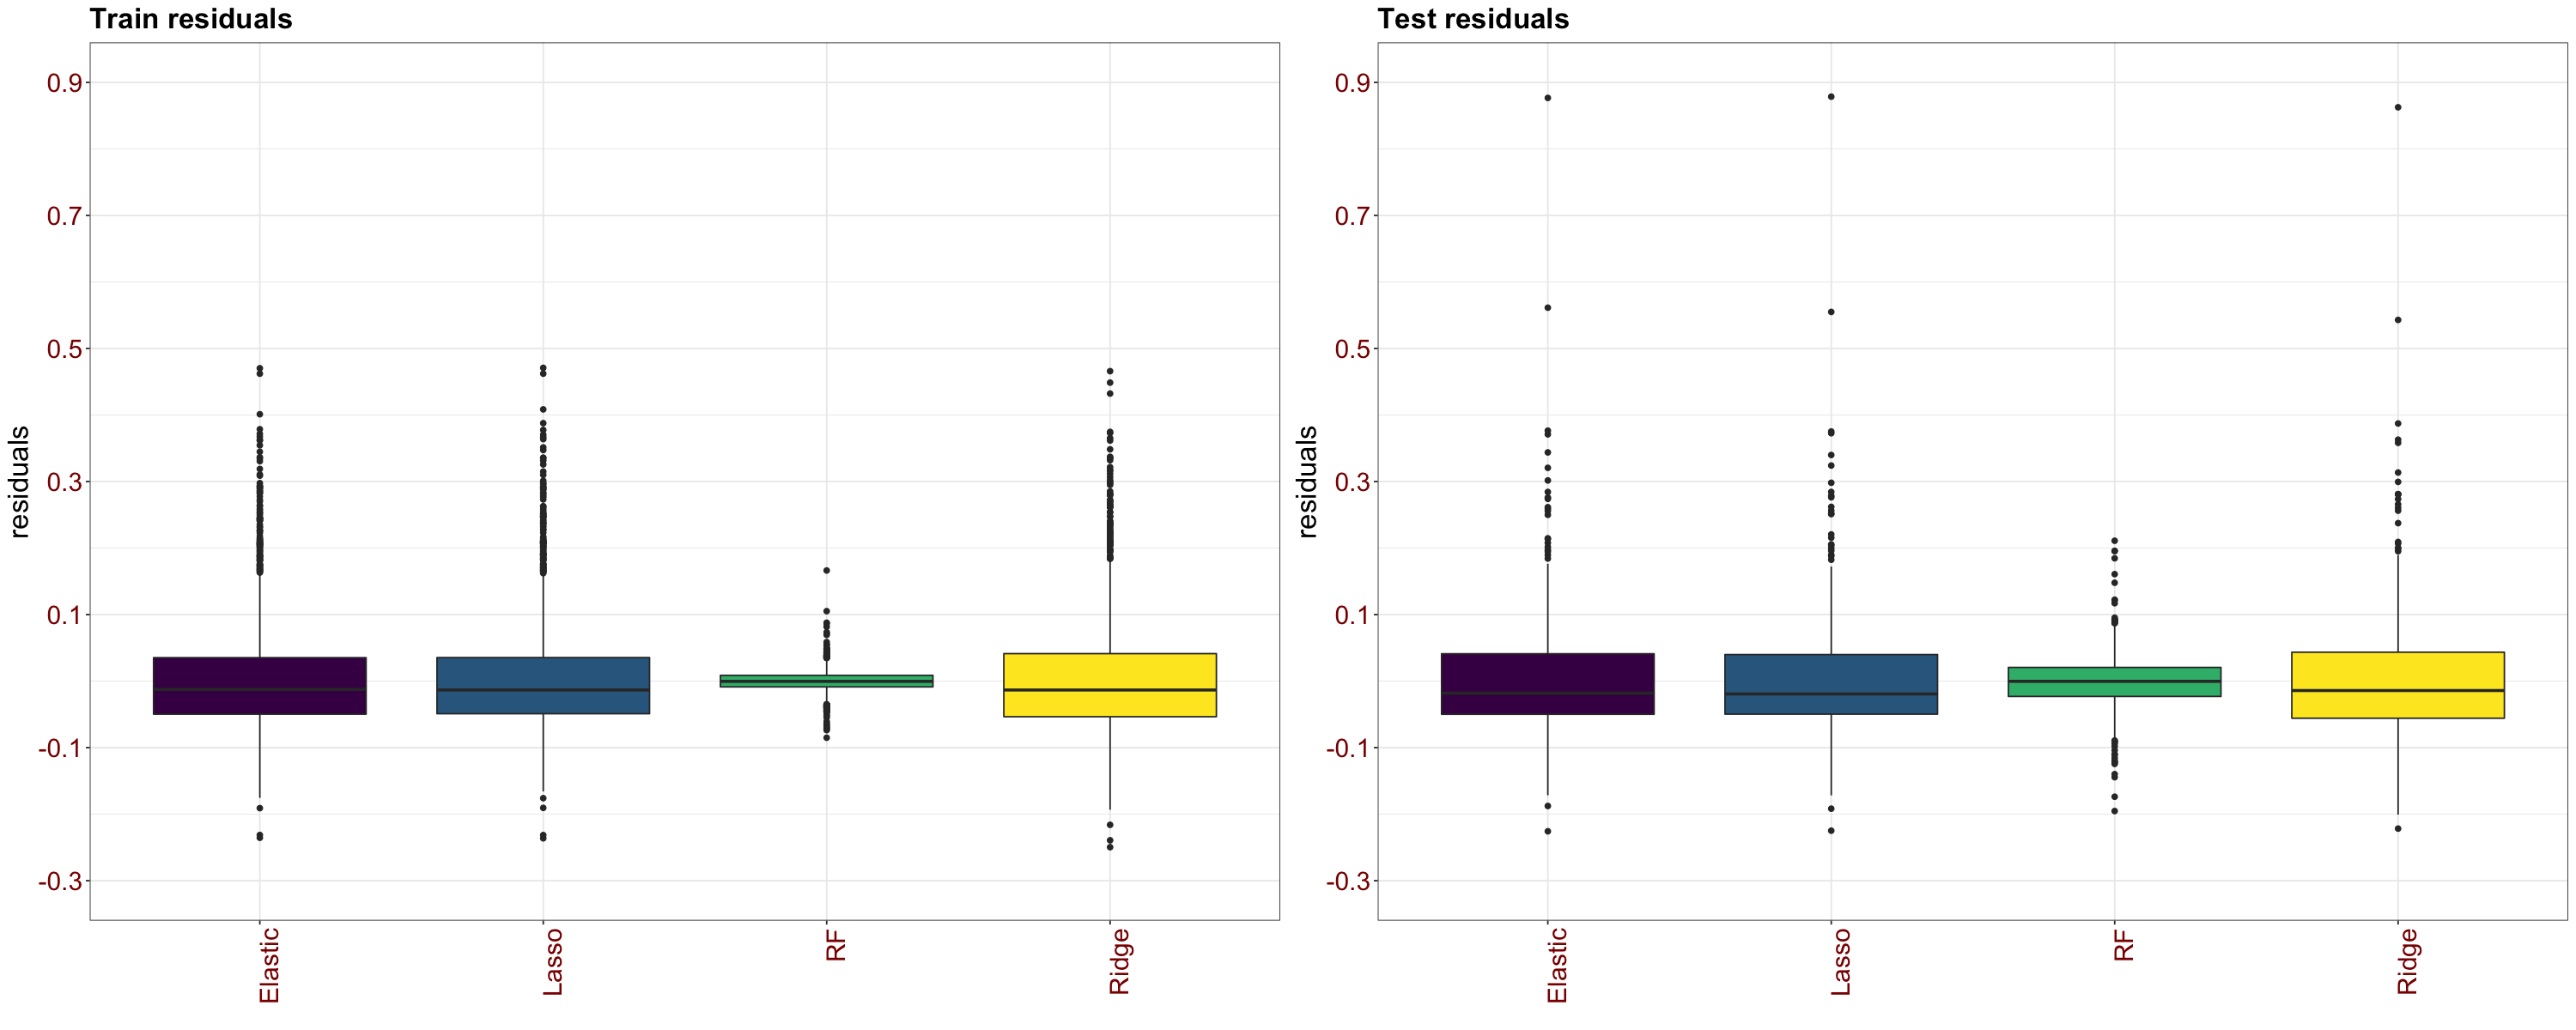

In [14]:
options(repr.plot.width=25, repr.plot.height=10)

limits <- c(-0.3, 0.9)
breaks <- seq(limits[1], limits[2], by=.2)

g1 <- train.resid %>%
  gather(key=models, value=residuals) %>%
  ggplot(aes(x=models, y=residuals, fill=models)) +
    geom_boxplot() +
    scale_y_continuous(limits=limits, breaks=breaks) + 
    scale_fill_viridis(discrete = TRUE, alpha=1, option="D") +
    scale_color_viridis(discrete = TRUE) +
    theme_bw() +
    theme(
      legend.position="none",
      plot.title = element_text(size=20, face = "bold"),
      axis.text.x = element_text(angle = 90, hjust = 1, size=18,color="darkred"),
      axis.text.y = element_text(hjust = 1, size=18,color="darkred"),
      axis.title.y = element_text(size = rel(1.8), angle = 90)
    ) +
    ggtitle("Train residuals") +
    xlab("")

g2 <- test.resid %>%
  gather(key=models, value=residuals) %>%
  ggplot(aes(x=models, y=residuals, fill=models)) +
    geom_boxplot() +
    scale_y_continuous(limits=limits, breaks=breaks) + 
    scale_fill_viridis(discrete = TRUE, alpha=1, option="D") +
    scale_color_viridis(discrete = TRUE) +
    theme_bw() +
    theme(
      legend.position="none",
      plot.title = element_text(size=20, , face = "bold"),
      axis.text.x = element_text(angle = 90, hjust = 1, size=18,color="darkred"),
      axis.text.y = element_text(hjust = 1, size=18,color="darkred"),
      axis.title.y = element_text(size = rel(1.8), angle = 90)
    ) +
    ggtitle("Test residuals") +
    xlab("")

grid.arrange(g1, g2, ncol=2)

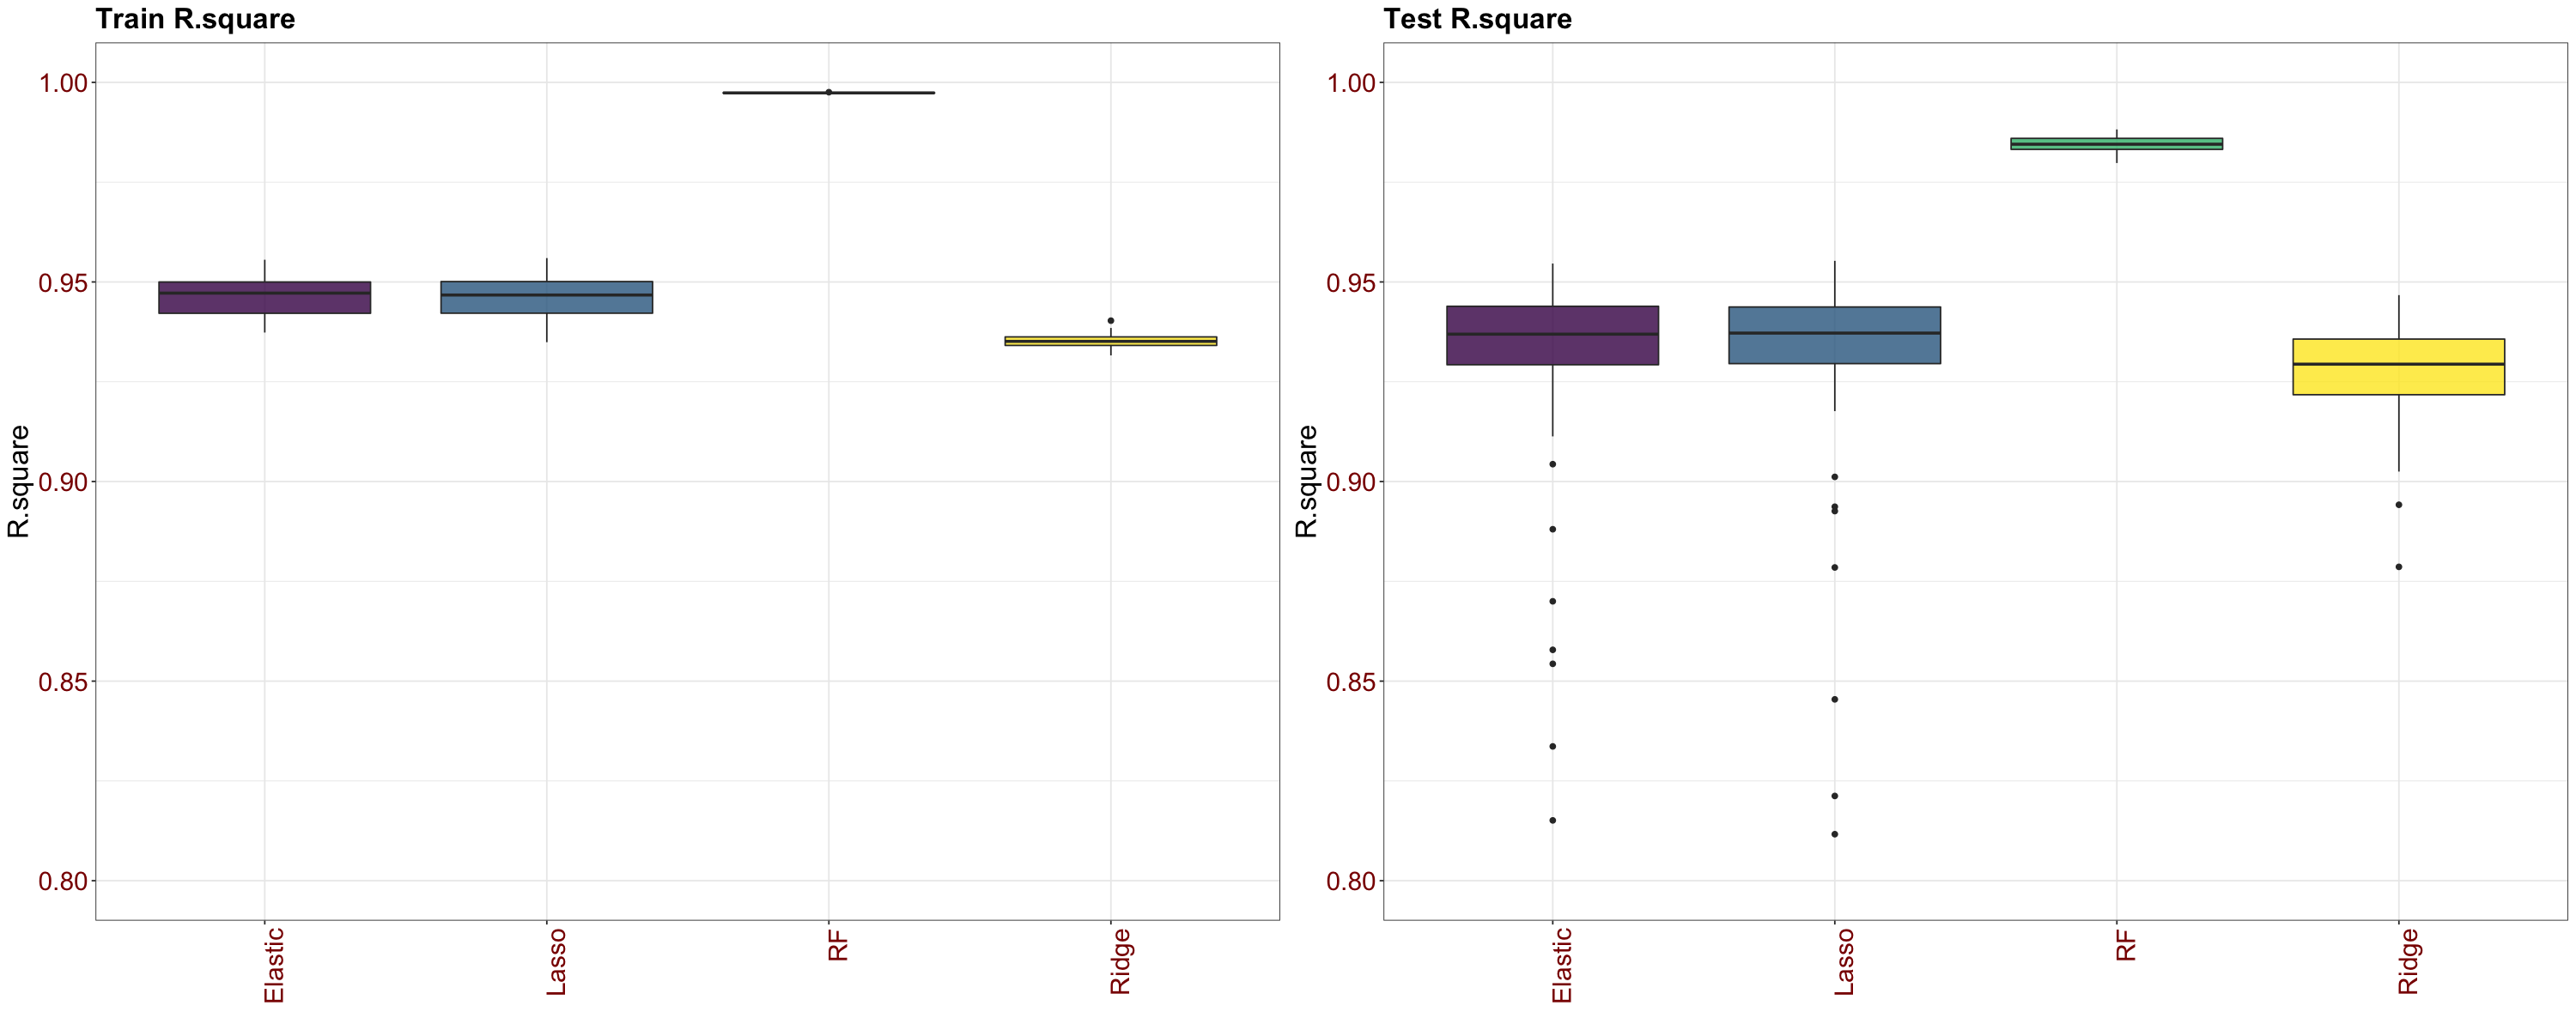

In [16]:
train.r2 <- data.frame(train.r2)
test.r2 <- data.frame(test.r2)
options(repr.plot.width=25, repr.plot.height=10)

limits <- c(0.8, 1)
breaks <- seq(limits[1], limits[2], by=.05)

g1 <- train.r2 %>%
  gather(key=models, value=R.square) %>%
  ggplot(aes(x=models, y=R.square, fill=models)) +
    geom_boxplot() +
    scale_y_continuous(limits=limits, breaks=breaks) + 
    scale_fill_viridis(discrete = TRUE, alpha=0.8, option="D") +
    scale_color_viridis(discrete = TRUE) +
    theme_bw() +
    theme(
      legend.position="none",
      plot.title = element_text(size=20, face = "bold"),
      axis.text.x = element_text(angle = 90, hjust = 1, size=18,color="darkred"),
      axis.text.y = element_text(hjust = 1, size=18,color="darkred"),
      axis.title.y = element_text(size = rel(1.8), angle = 90)
    ) +
    ggtitle("Train R.square") +
    xlab("")

g2 <- test.r2 %>%
  gather(key=models, value=R.square) %>%
  ggplot(aes(x=models, y=R.square, fill=models)) +
    geom_boxplot() +
    scale_y_continuous(limits=limits, breaks=breaks) + 
    scale_fill_viridis(discrete = TRUE, alpha=0.8, option="D") +
    scale_color_viridis(discrete = TRUE) +
    theme_bw() +
    theme(
      legend.position="none",
      plot.title = element_text(size=20, , face = "bold"),
      axis.text.x = element_text(angle = 90, hjust = 1, size=18,color="darkred"),
      axis.text.y = element_text(hjust = 1, size=18,color="darkred"),
      axis.title.y = element_text(size = rel(1.8), angle = 90)
    ) +
    ggtitle("Test R.square") +
    xlab("")

grid.arrange(g1, g2, ncol=2)

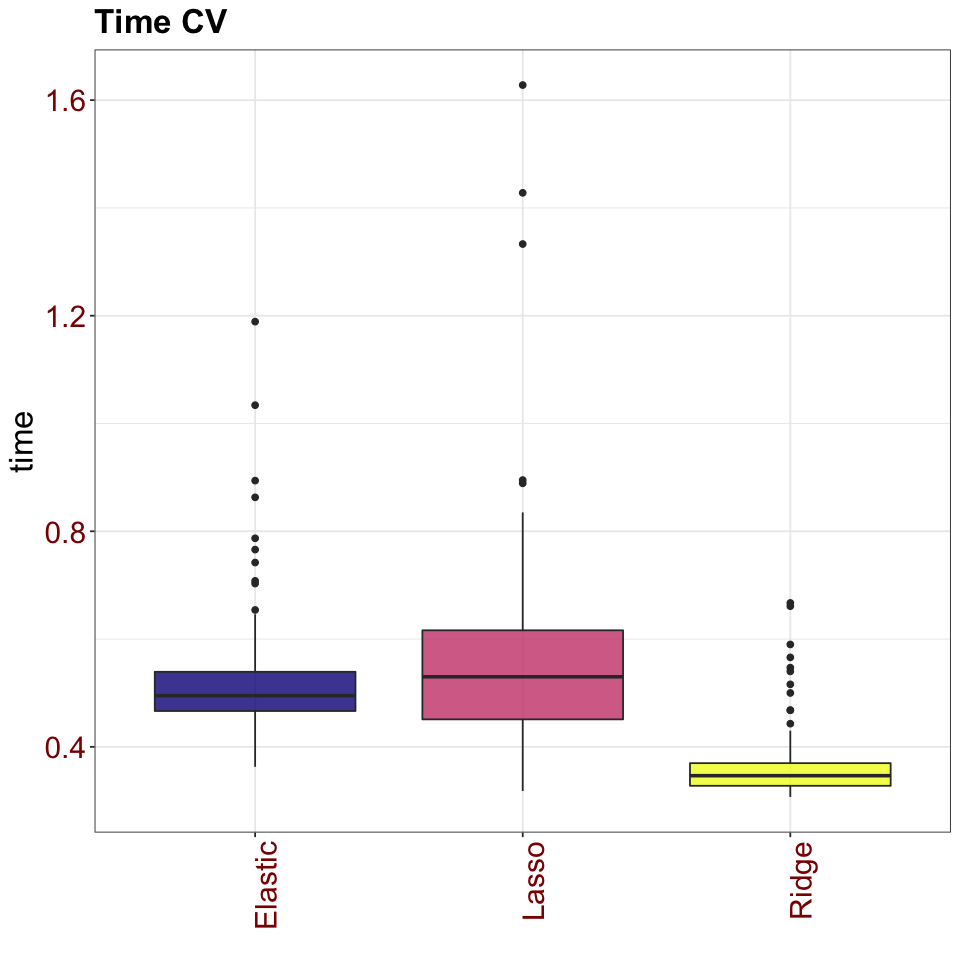

In [17]:
# time cv
options(repr.plot.width=8, repr.plot.height=8)
time.cv <- data.frame(time.cv)
time.cv %>%
  gather(key=models, value=time) %>%
  ggplot(aes(x=models, y=time, fill=models)) +
    geom_boxplot() +
    #scale_y_continuous(limits=limits, breaks=breaks) + 
    scale_fill_viridis(discrete = TRUE, alpha=0.8, option="C") +
    scale_color_viridis(discrete = TRUE) +
    theme_bw() +
    theme(
      legend.position="none",
      plot.title = element_text(size=20, face = "bold"),
      axis.text.x = element_text(angle = 90, hjust = 1, size=18,color="darkred"),
      axis.text.y = element_text(hjust = 1, size=18,color="darkred"),
      axis.title.y = element_text(size = rel(1.8), angle = 90)
    ) +
    ggtitle("Time CV") +
    xlab("")

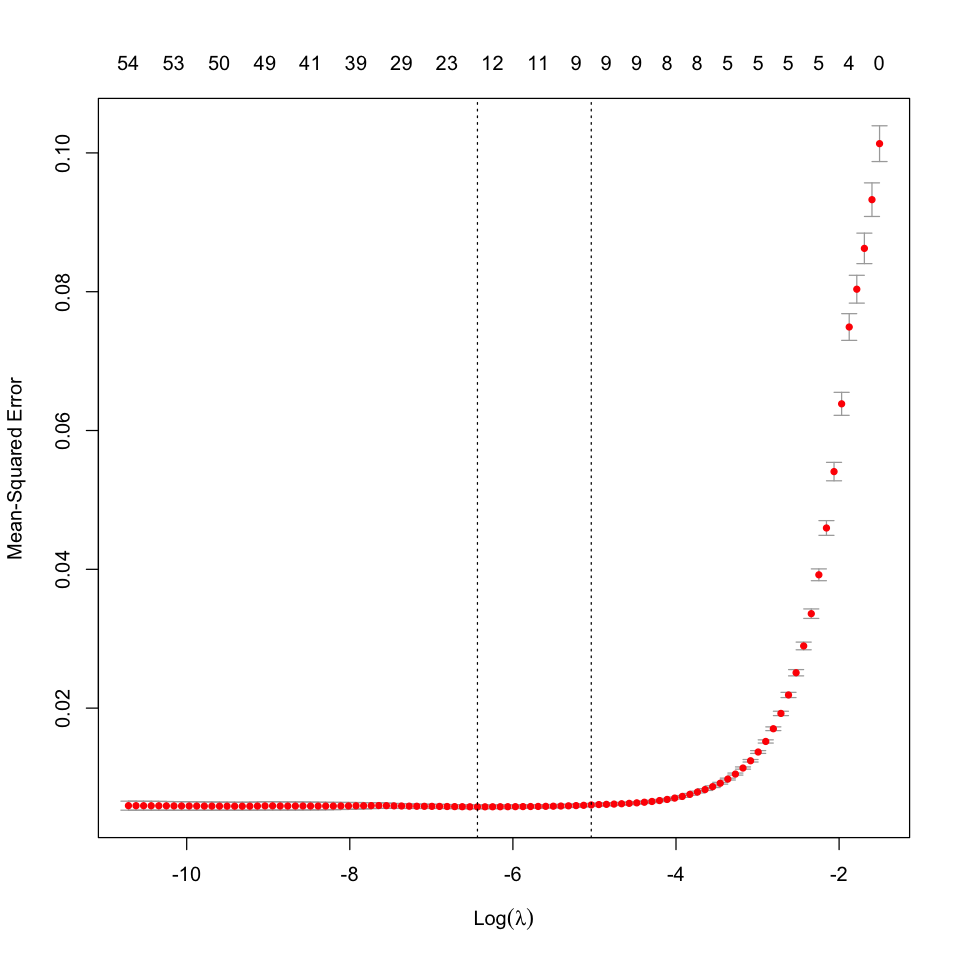

In [21]:
plot(cv.lasso, main="")

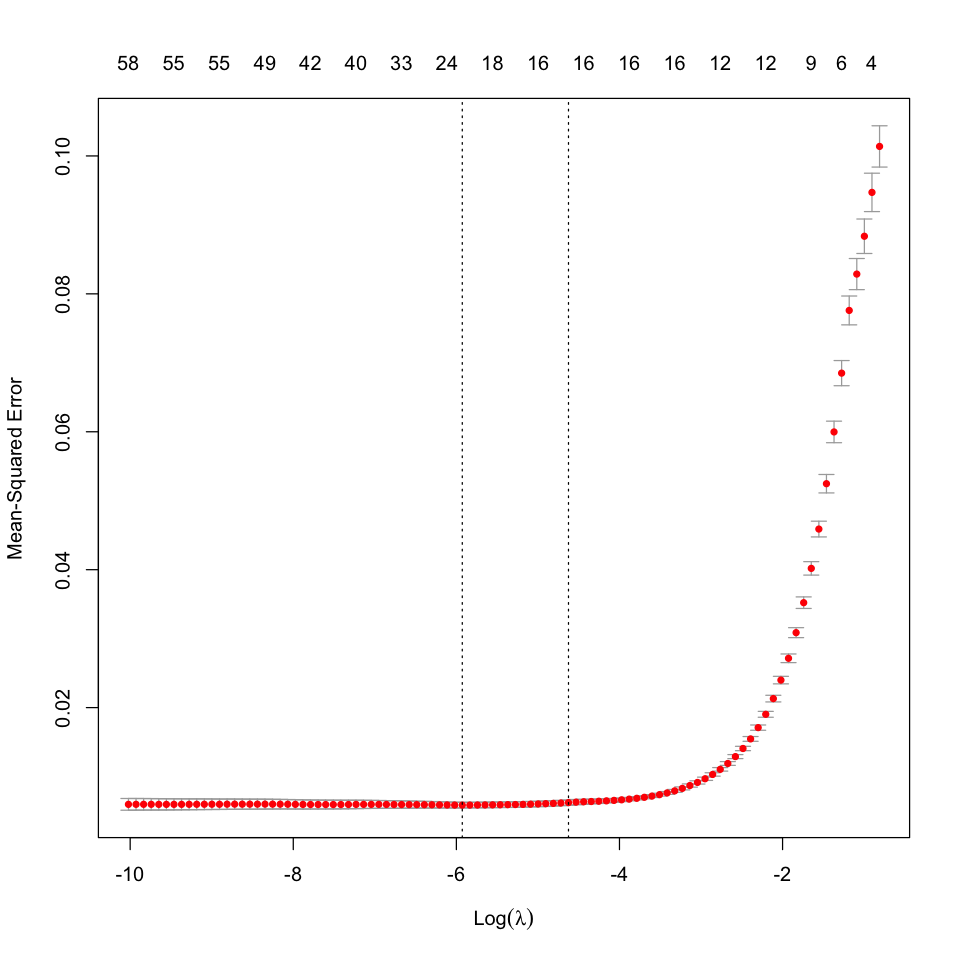

In [22]:
plot(cv.el, main="")

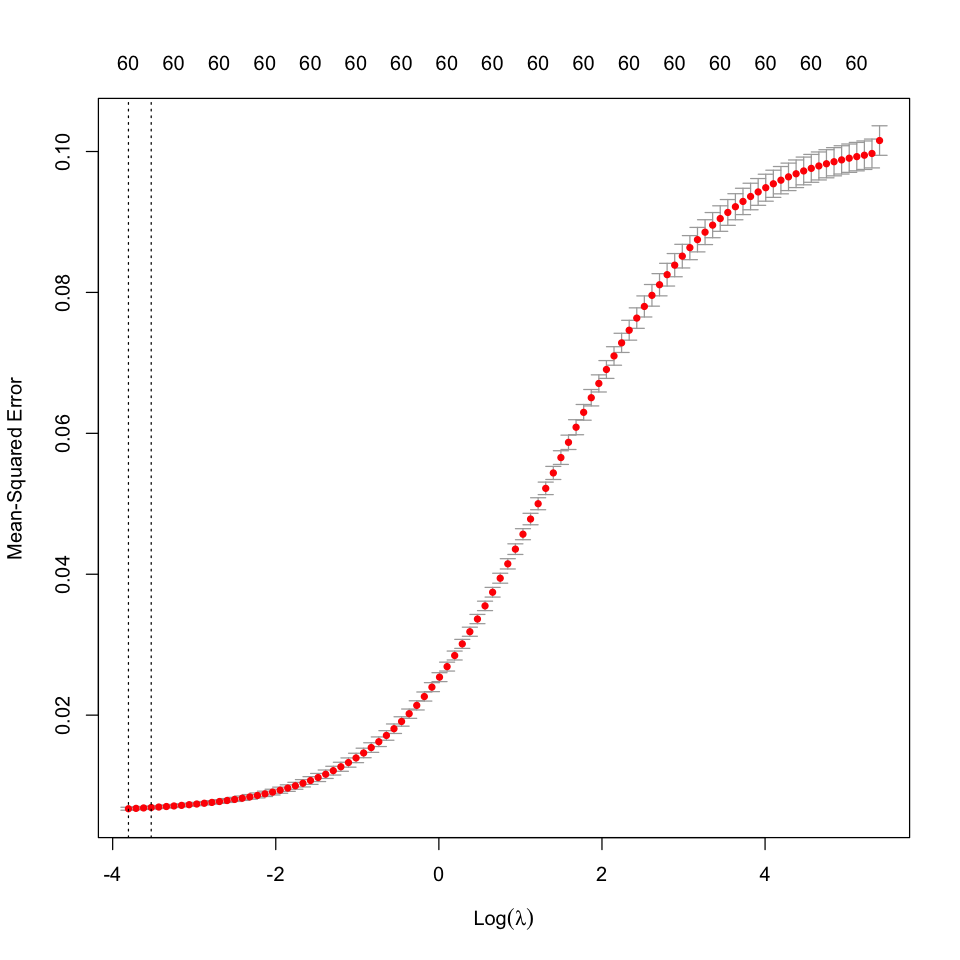

In [23]:
plot(cv.rid, main="")

quartz_off_screen 
                3

pdf 
  2

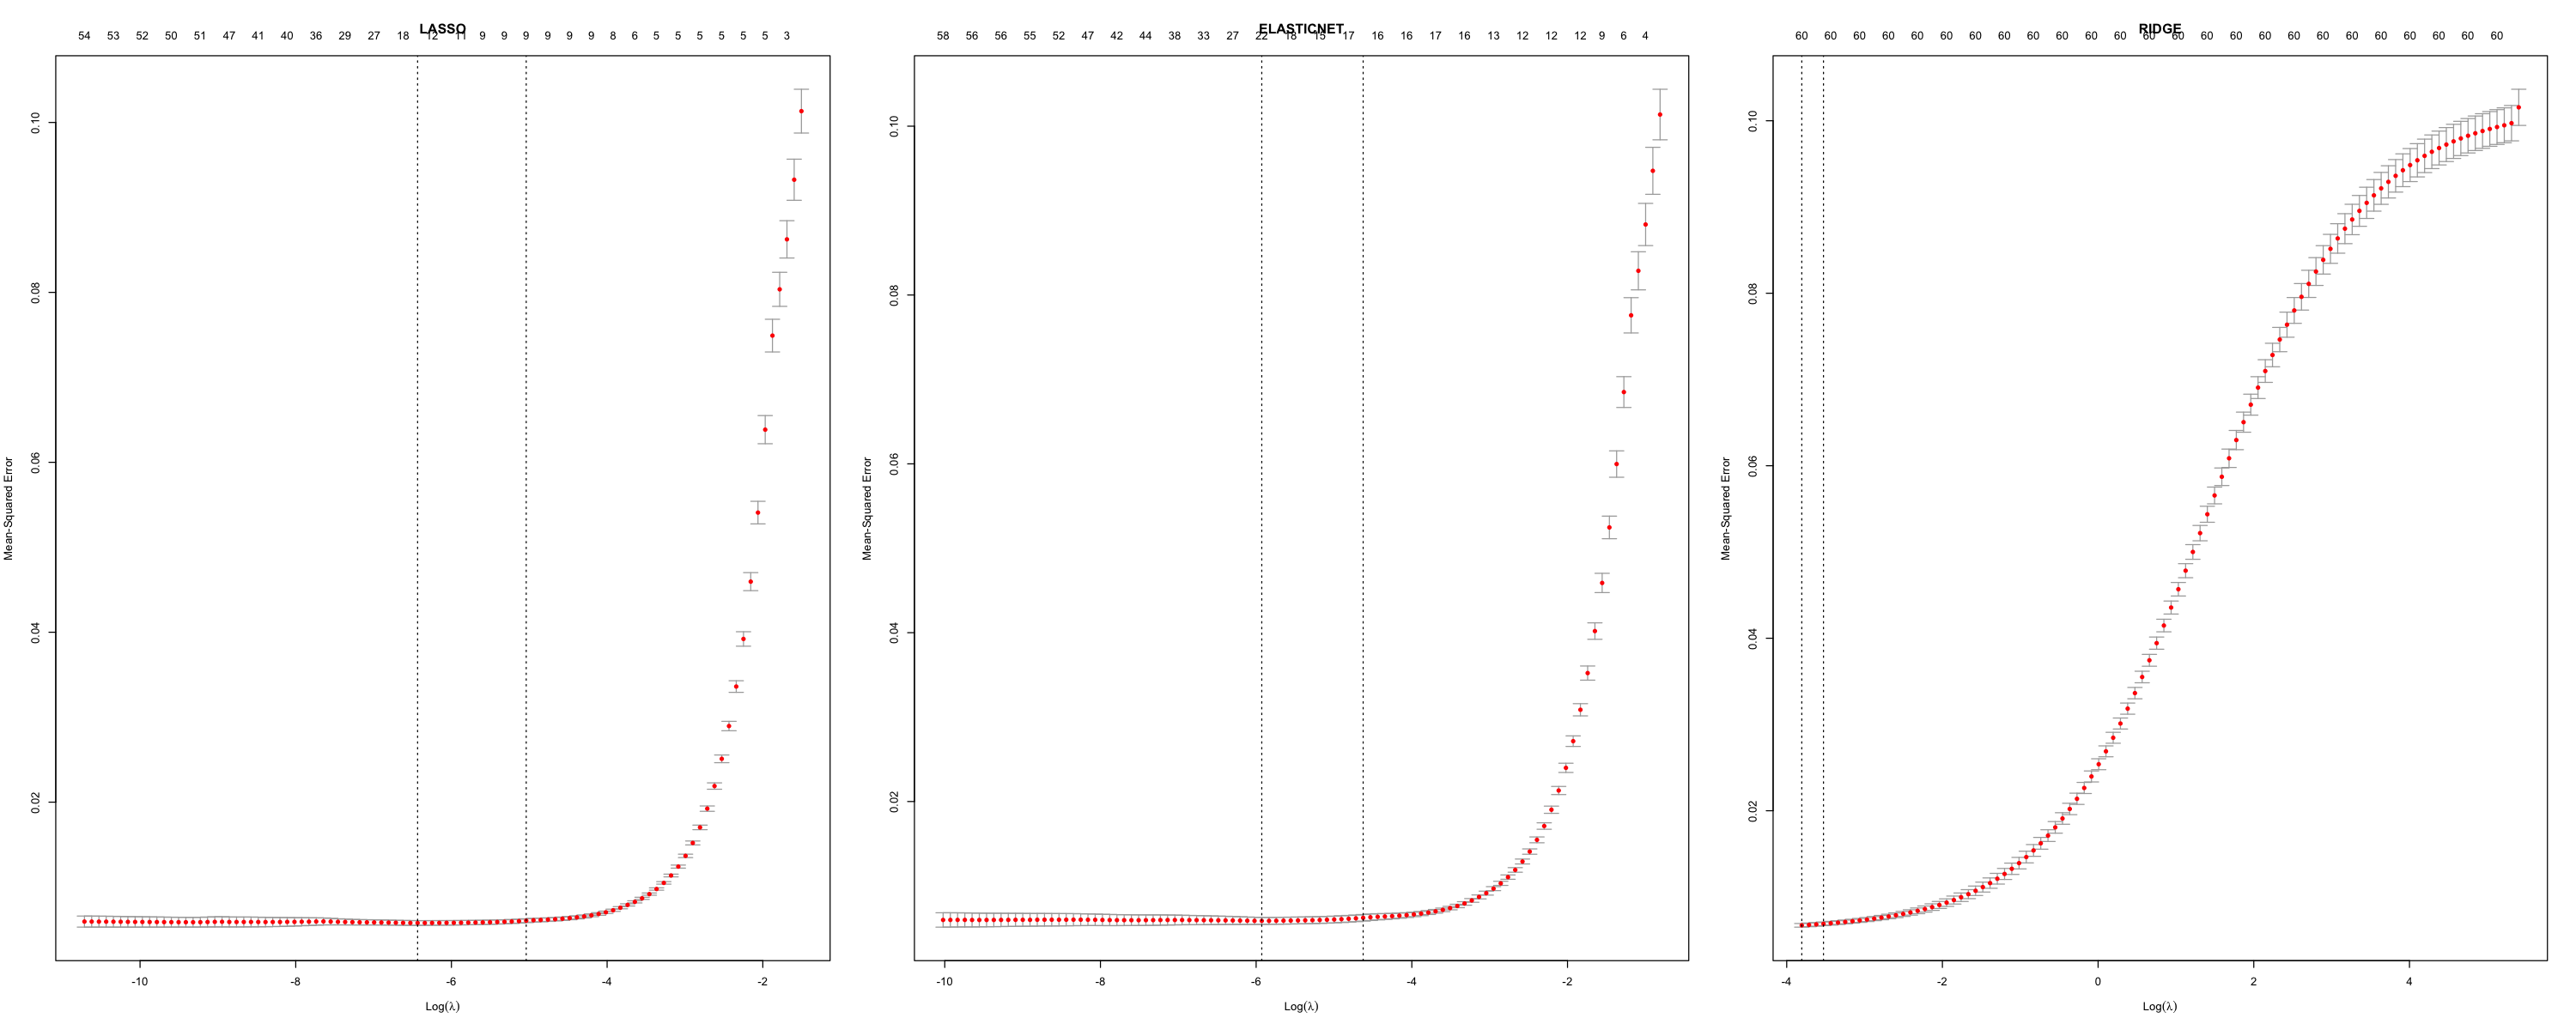

In [32]:
# make cv plot

par(mfrow=c(1,3))
options(repr.plot.width=25, repr.plot.height=10)
plot(cv.lasso, main='LASSO' )
plot(cv.el, main='ELASTICNET')
plot(cv.rid, main="RIDGE")
dev.copy(jpeg, filename="cv_curve.jpg");
dev.off();


In [11]:
# perform 100 boostrapping samples to find sd of estimated coefficients
p               <-  dim(c17)[2]-1
n               <-  dim(c17)[1]
bootstrapSamples =     100
time.bs          <-    matrix(0, nrow = bootstrapSamples, ncol=4)
beta.rf.bs       =     matrix(0, nrow = bootstrapSamples, ncol=p)    
beta.ls.bs       =     matrix(0, nrow = bootstrapSamples, ncol=p)         
beta.en.bs       =     matrix(0, nrow = bootstrapSamples, ncol=p)         
beta.rd.bs       =     matrix(0, nrow = bootstrapSamples, ncol=p)         

for (m in 1:bootstrapSamples){
  bs_indexes       =     sample(n, replace=T)
  X.bs             =     X[bs_indexes, ]
  y.bs             =     y[bs_indexes]

  ##########lasso
  a                =     1 # lasso
  start.time       <-    proc.time()
  ls.cv.fit           =     cv.glmnet(X.bs, y.bs, alpha = a, nfolds = 10)
  ls.fit              =     glmnet(X.bs, y.bs, alpha = a, lambda = ls.cv.fit$lambda.min)
  end.time         <-    proc.time() - start.time
  time.bs[m,1]     <-    end.time['elapsed'] 
  beta.ls.bs[m,]   =     as.vector(ls.fit$beta)
  
  ############el
  a                =     0.5 # elastic-net
  start.time       <-    proc.time()
  el.cv.fit           =     cv.glmnet(X.bs, y.bs, alpha = a, nfolds = 10)
  el.fit              =     glmnet(X.bs, y.bs, alpha = a, lambda = el.cv.fit$lambda.min)
  end.time         <-    proc.time() - start.time
  time.bs[m,2]     <-    end.time['elapsed']
  beta.en.bs[m,]   =     as.vector(el.fit$beta)

  ############ridge
  a                =     0 # ridge
  start.time       <-    proc.time()
  rd.cv.fit           =     cv.glmnet(X.bs, y.bs, alpha = a, nfolds = 10)
  rd.fit              =     glmnet(X.bs, y.bs, alpha = a, lambda = rd.cv.fit$lambda.min)  
  end.time         <-    proc.time() - start.time
  time.bs[m,3]     <-    end.time['elapsed']
  beta.rd.bs[m,]   =     as.vector(rd.fit$beta)

  #############rf
  start.time       <-    proc.time()
  rf               =     randomForest(X.bs, y.bs, mtry = sqrt(p), importance = TRUE)
  beta.rf.bs[m,]   =     as.vector(rf$importance[,1])
  end.time         <-    proc.time() - start.time
  time.bs[m,4]     <-    end.time['elapsed']
  cat(sprintf("Bootstrap Sample %3.f \n", m))
}


Bootstrap Sample   1 
Bootstrap Sample   2 
Bootstrap Sample   3 
Bootstrap Sample   4 
Bootstrap Sample   5 
Bootstrap Sample   6 
Bootstrap Sample   7 
Bootstrap Sample   8 
Bootstrap Sample   9 
Bootstrap Sample  10 
Bootstrap Sample  11 
Bootstrap Sample  12 
Bootstrap Sample  13 
Bootstrap Sample  14 
Bootstrap Sample  15 
Bootstrap Sample  16 
Bootstrap Sample  17 
Bootstrap Sample  18 
Bootstrap Sample  19 
Bootstrap Sample  20 
Bootstrap Sample  21 
Bootstrap Sample  22 
Bootstrap Sample  23 
Bootstrap Sample  24 
Bootstrap Sample  25 
Bootstrap Sample  26 
Bootstrap Sample  27 
Bootstrap Sample  28 
Bootstrap Sample  29 
Bootstrap Sample  30 
Bootstrap Sample  31 
Bootstrap Sample  32 
Bootstrap Sample  33 
Bootstrap Sample  34 
Bootstrap Sample  35 
Bootstrap Sample  36 
Bootstrap Sample  37 
Bootstrap Sample  38 
Bootstrap Sample  39 
Bootstrap Sample  40 
Bootstrap Sample  41 
Bootstrap Sample  42 
Bootstrap Sample  43 
Bootstrap Sample  44 
Bootstrap Sample  45 
Bootstrap 

In [12]:
colnames(time.bs)  <- c("Lasso", "Elastic", "Ridge", "RF")
colnames(beta.rf.bs) <- colnames(c17[,-1])
colnames(beta.ls.bs) <- colnames(c17[,-1])
colnames(beta.en.bs) <- colnames(c17[,-1])
colnames(beta.rd.bs) <- colnames(c17[,-1])


In [16]:
# write.csv(time.bs, file ="time_bs.csv")
# write.csv(beta.ls.bs, file ="beta_ls_bs.csv")
# write.csv(beta.en.bs, file ="beta_en_bs.csv")
# write.csv(beta.rd.bs, file ="beta_rd_bs.csv")
# write.csv(beta.rf.bs, file ="beta_rf_bs.csv")

In [11]:
beta.ls.bs <- read.csv("beta_ls_bs.csv")[,-1]
beta.en.bs <- read.csv("beta_en_bs.csv")[,-1]
beta.rd.bs <- read.csv("beta_rd_bs.csv")[,-1]
beta.rf.bs <- read.csv("beta_rf_bs.csv")[,-1]
time.bs <- read.csv("time_bs.csv")[,-1]

In [13]:
ls.bs.sd <- apply(beta.ls.bs, 2, sd)
en.bs.sd <- apply(beta.en.bs, 2, sd)
rd.bs.sd <- apply(beta.rd.bs, 2, sd)
rf.bs.sd <- apply(beta.rf.bs, 2, sd)

In [35]:
length(y)

[1] 3438

In [29]:
length(colnames(X))

[1] 60

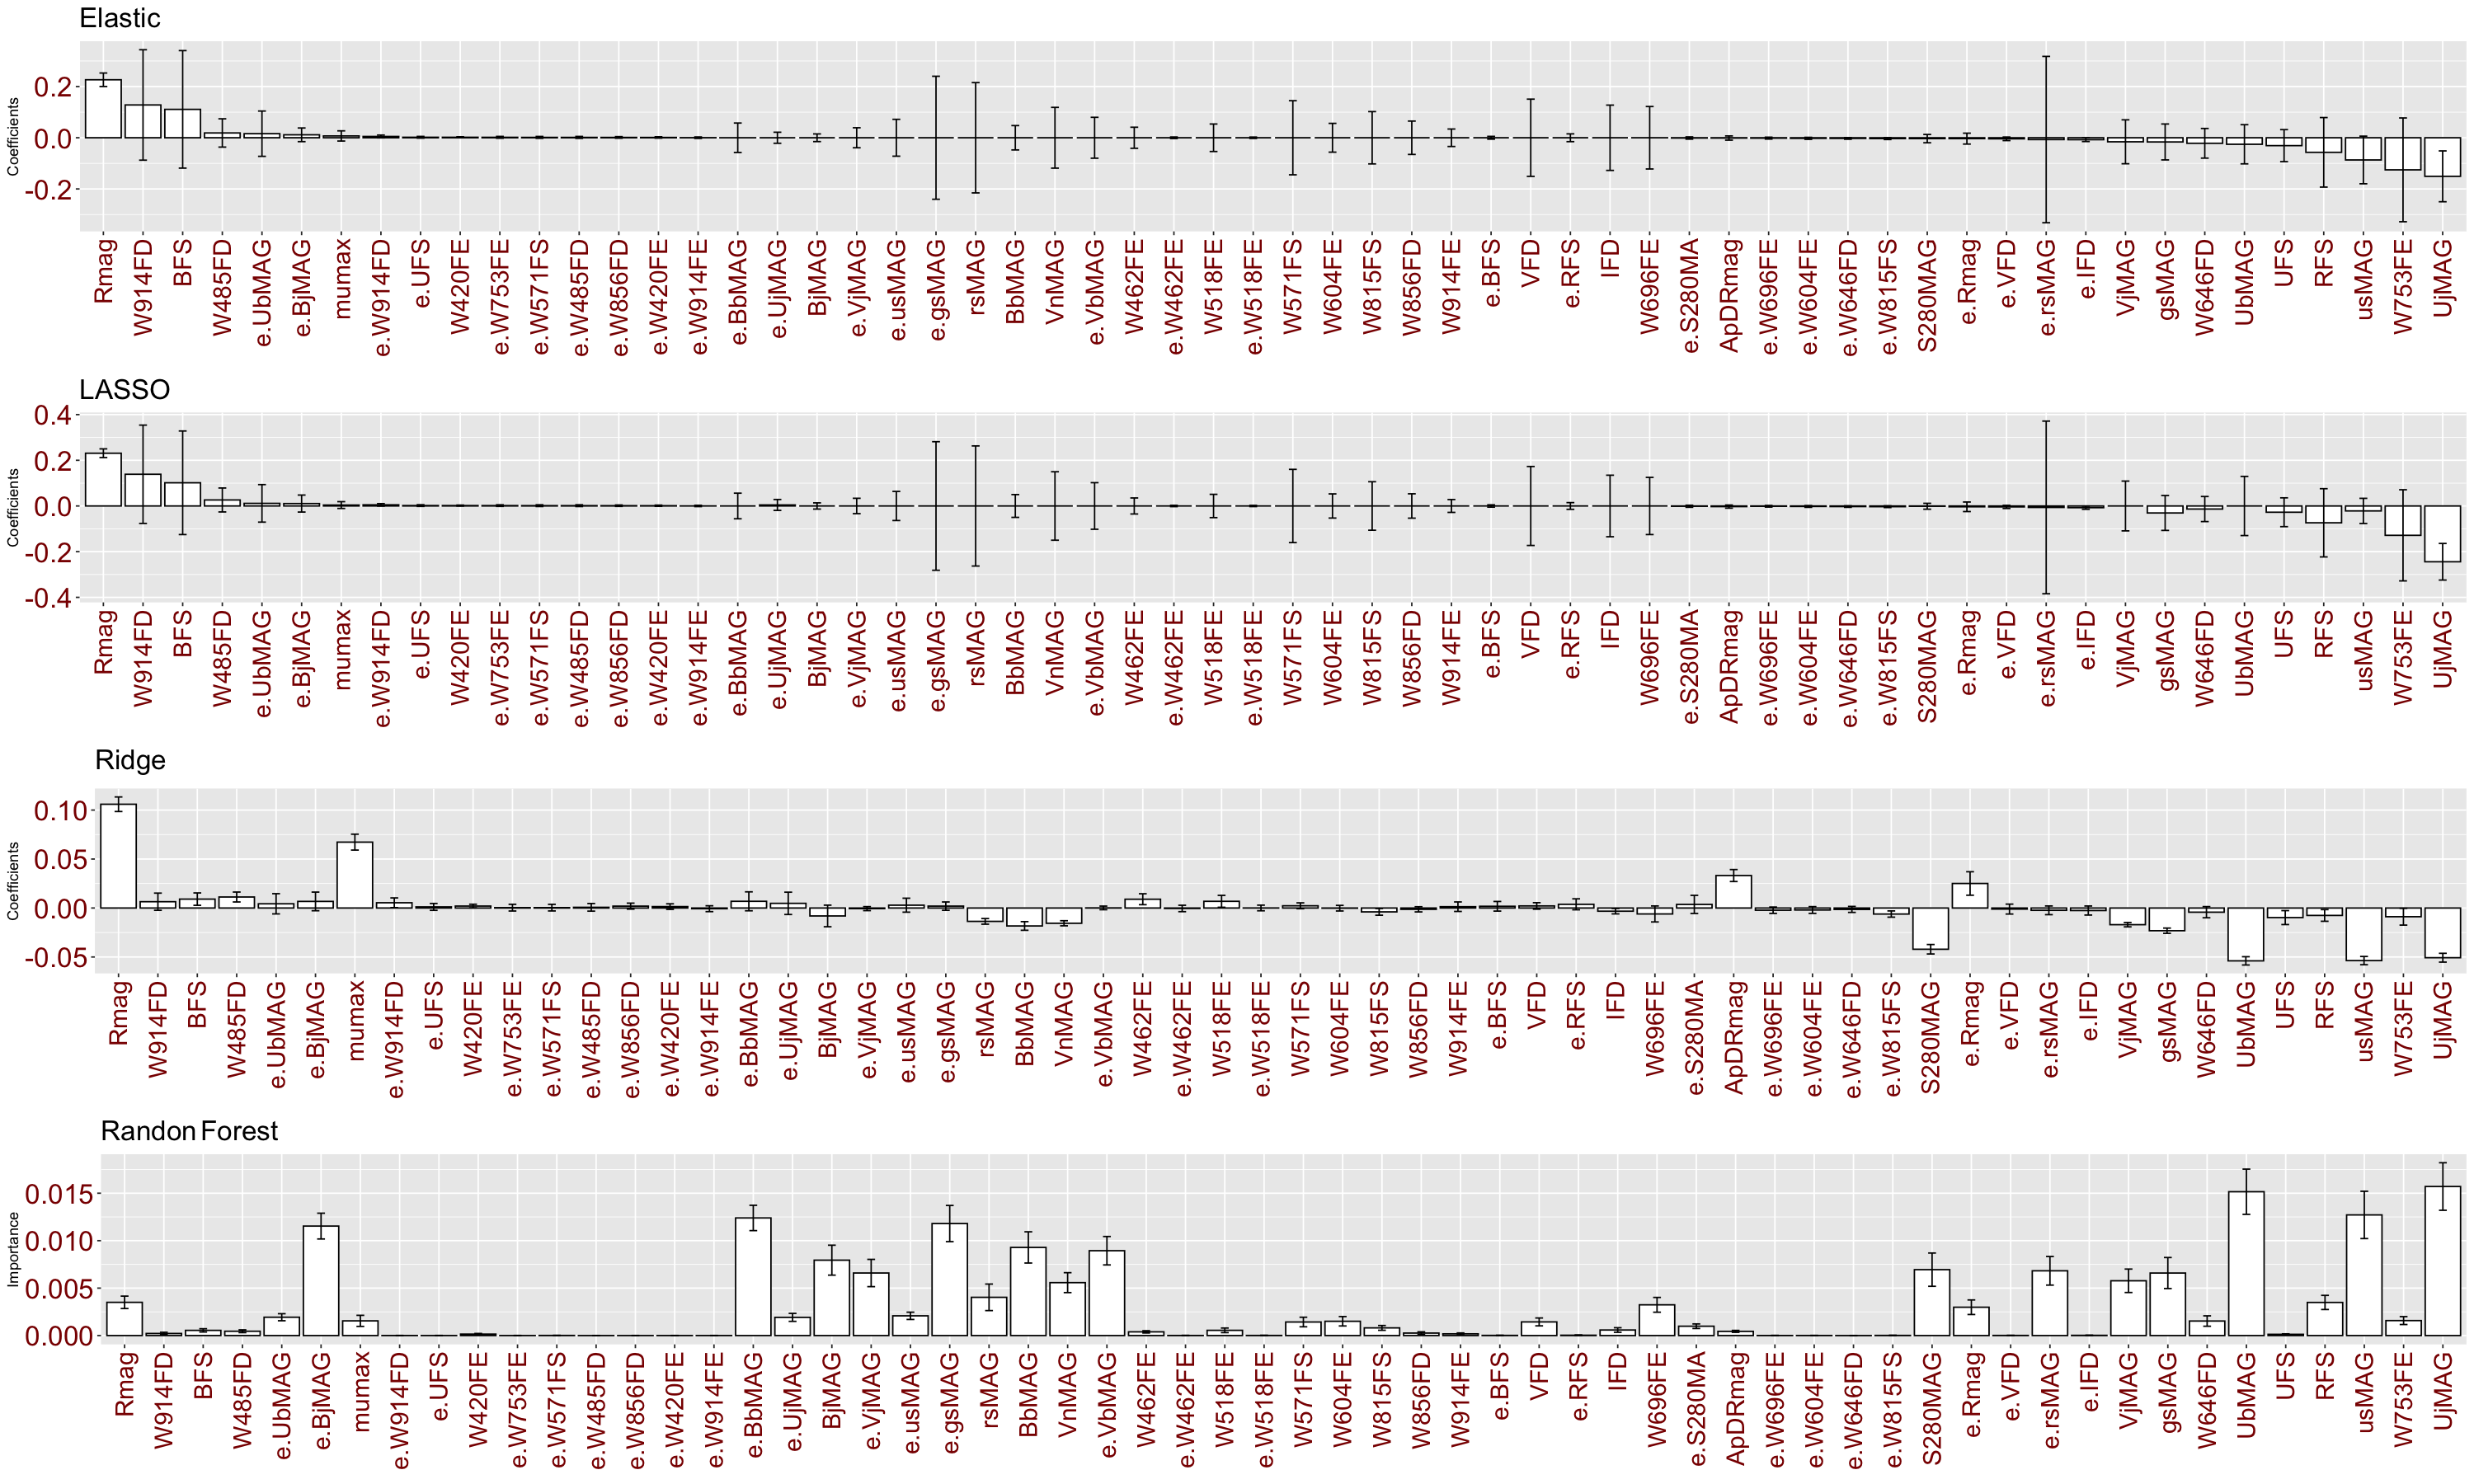

In [14]:
# fit lasso to the whole data
a=1 # lasso
start.time       <-    proc.time()
cv.fit           =     cv.glmnet(X, y, alpha = a, nfolds = 10)
ls.fit              =     glmnet(X, y, alpha = a, lambda = cv.fit$lambda.min)
end.time         <-    proc.time() - start.time
time.ls          <-    end.time['elapsed'] 
betaS.ls               =     data.frame(colnames(X), as.vector(ls.fit$beta), 2*ls.bs.sd)
colnames(betaS.ls)     =     c( "feature", "value", "err")

# fit en to the whole data
a=0.5 # elastic-net
start.time       <-    proc.time()
cv.fit           =     cv.glmnet(X, y, alpha = a, nfolds = 10)
el.fit              =     glmnet(X, y, alpha = a, lambda = cv.fit$lambda.min)
end.time         <-    proc.time() - start.time
time.el          <-    end.time['elapsed']
betaS.en               =     data.frame(colnames(X), as.vector(el.fit$beta), 2*en.bs.sd)
colnames(betaS.en)     =     c( "feature", "value", "err")

# fit ridge to the whole data
a=0 # ridge
start.time       <-    proc.time()
cv.fit           =     cv.glmnet(X, y, alpha = a, nfolds = 10)
rd.fit              =     glmnet(X, y, alpha = a, lambda = cv.fit$lambda.min)
end.time         <-    proc.time() - start.time
time.rd          <-    end.time['elapsed']
betaS.rd               =     data.frame(colnames(X), as.vector(rd.fit$beta), 2*rd.bs.sd)
colnames(betaS.rd)     =     c( "feature", "value", "err")

# fit rf to the whole data
start.time       <-    proc.time()
rf               =     randomForest(X, y, mtry = sqrt(p), importance = TRUE)
end.time         <-    proc.time() - start.time
time.rf          <-    end.time['elapsed']
betaS.rf               =     data.frame(colnames(X), as.vector(rf$importance[,1]), 2*rf.bs.sd)
colnames(betaS.rf)     =     c( "feature", "value", "err")

# we need to change the order of factor levels by specifying the order explicitly.
betaS.en$feature     =  factor(betaS.en$feature, levels = betaS.en$feature[order(betaS.en$value, decreasing = TRUE)])
betaS.ls$feature     =  factor(betaS.ls$feature, levels = betaS.en$feature[order(betaS.en$value, decreasing = TRUE)])
betaS.rd$feature     =  factor(betaS.rd$feature, levels = betaS.en$feature[order(betaS.en$value, decreasing = TRUE)])
betaS.rf$feature     =  factor(betaS.rf$feature, levels = betaS.en$feature[order(betaS.en$value, decreasing = TRUE)])

options(repr.plot.width=25, repr.plot.height=15)
en =  ggplot(betaS.en, aes(x=feature, y=value)) +
  geom_bar(stat = "identity", fill="white", colour="black")    +
  geom_errorbar(aes(ymin=value-err, ymax=value+err), width=.2) +
  labs(x = element_blank(), y = "Coefficients", title = expression(Elastic)) +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1, size=18,color="darkred"),
        axis.text.y = element_text(hjust = 1, size=20, color="darkred"),
        plot.title = element_text(size=20, , face = "bold"))

ls =  ggplot(betaS.ls, aes(x=feature, y=value)) +
  geom_bar(stat = "identity", fill="white", colour="black")    +
  geom_errorbar(aes(ymin=value-err, ymax=value+err), width=.2) +
  labs(x = element_blank(), y = "Coefficients", title = expression(LASSO)) +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1, size=18,color="darkred"),
        axis.text.y = element_text(hjust = 1, size=20, color="darkred"),
        plot.title = element_text(size=20, , face = "bold"))

rd =  ggplot(betaS.rd, aes(x=feature, y=value)) +
  geom_bar(stat = "identity", fill="white", colour="black")    +
  geom_errorbar(aes(ymin=value-err, ymax=value+err), width=.2) +
  labs(x = element_blank(), y = "Coefficients", title = expression(Ridge)) +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1, size=18,color="darkred"),
        axis.text.y = element_text(hjust = 1, size=20, color="darkred"),
        plot.title = element_text(size=20, , face = "bold"))

rf =  ggplot(betaS.rf, aes(x=feature, y=value)) +
  geom_bar(stat = "identity", fill="white", colour="black")    +
  geom_errorbar(aes(ymin=value-err, ymax=value+err), width=.2) +
  labs(x = element_blank(), y = "Importance", title = expression(Randon~Forest)) +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1, size=18,color="darkred"),
        axis.text.y = element_text(hjust = 1, size=20, color="darkred"),
        plot.title = element_text(size=20, , face = "bold"))

grid.arrange(en, ls, rd, rf, nrow = 4)


In [15]:
print(time.ls)
print(time.el)
print(time.rd)
print(time.rf)

elapsed 
  0.623 
elapsed 
  0.595 
elapsed 
  0.409 
elapsed 
 39.352 


In [4]:
colMeans(test.r2)

Lasso   Elastic     Ridge        RF 
0.9373508 0.9368936 0.9290311 0.9999676

In [24]:
quantile(test.r2[,1], c(.10, .90))
quantile(test.r2[,2], c(.10, .90)) 
quantile(test.r2[,3], c(.10, .90)) 
quantile(test.r2[,4], c(.10, .90)) 

10%       90% 
0.9218361 0.9475419

10%       90% 
0.9196221 0.9484750

10%       90% 
0.9107033 0.9385576

10%       90% 
0.9814439 0.9868057

In [9]:
quantile(test.r2[,2], c(.10, .90)) 

10%       90% 
0.9215715 0.9513389

In [10]:
quantile(test.r2[,3], c(.10, .90)) 

10%       90% 
0.9123747 0.9403610

In [11]:
quantile(test.r2[,4], c(.10, .90)) 

10%       90% 
0.9999125 0.9999997

In [51]:
apply(test.r2, 2, sd)

Lasso      Elastic        Ridge           RF 
1.722513e-02 1.830584e-02 1.117491e-02 3.993908e-05

In [52]:
colMeans(time.bs)

Lasso  Elastic    Ridge       RF 
 0.72652  0.67216  0.48337 42.49673

In [53]:
apply(time.bs, 2, sd)

Lasso   Elastic     Ridge        RF 
0.1963935 0.1619709 0.1696216 6.0719303

Xbar +- z(alpha/2) * sigma/sqrt(n)

In [63]:
colMeans(test.r2) + (qnorm(.95)*apply(test.r2, 2, sd)/sqrt(nrow(test.r2)))

Lasso   Elastic     Ridge        RF 
0.9401841 0.9399046 0.9308692 0.9999742

In [64]:
colMeans(test.r2) - (qnorm(.95)*apply(test.r2, 2, sd)/sqrt(nrow(test.r2)))

Lasso   Elastic     Ridge        RF 
0.9345175 0.9338825 0.9271930 0.9999610

Xbar +- t(alpha/2, df) * s/sqrt(n)

In [65]:
colMeans(test.r2) + (qt(.95, nrow(test.r2)-1)*apply(test.r2, 2, sd)/sqrt(nrow(test.r2)))

Lasso   Elastic     Ridge        RF 
0.9402109 0.9399330 0.9308866 0.9999742

In [66]:
colMeans(test.r2) - (qt(.95, nrow(test.r2)-1)*apply(test.r2, 2, sd)/sqrt(nrow(test.r2)))

Lasso   Elastic     Ridge        RF 
0.9344908 0.9338541 0.9271756 0.9999610

In [67]:
colMeans(time.bs) + (qt(.95, nrow(time.bs)-1)*apply(time.bs, 2, sd)/sqrt(nrow(time.bs)))
colMeans(time.bs) - (qt(.95, nrow(time.bs)-1)*apply(time.bs, 2, sd)/sqrt(nrow(time.bs)))

Lasso    Elastic      Ridge         RF 
 0.7591290  0.6990535  0.5115338 43.5049079

Lasso    Elastic      Ridge         RF 
 0.6939110  0.6452665  0.4552062 41.4885521

In [2]:
colMeans(time.bs)

Lasso  Elastic    Ridge       RF 
 0.72652  0.67216  0.48337 42.49673

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'



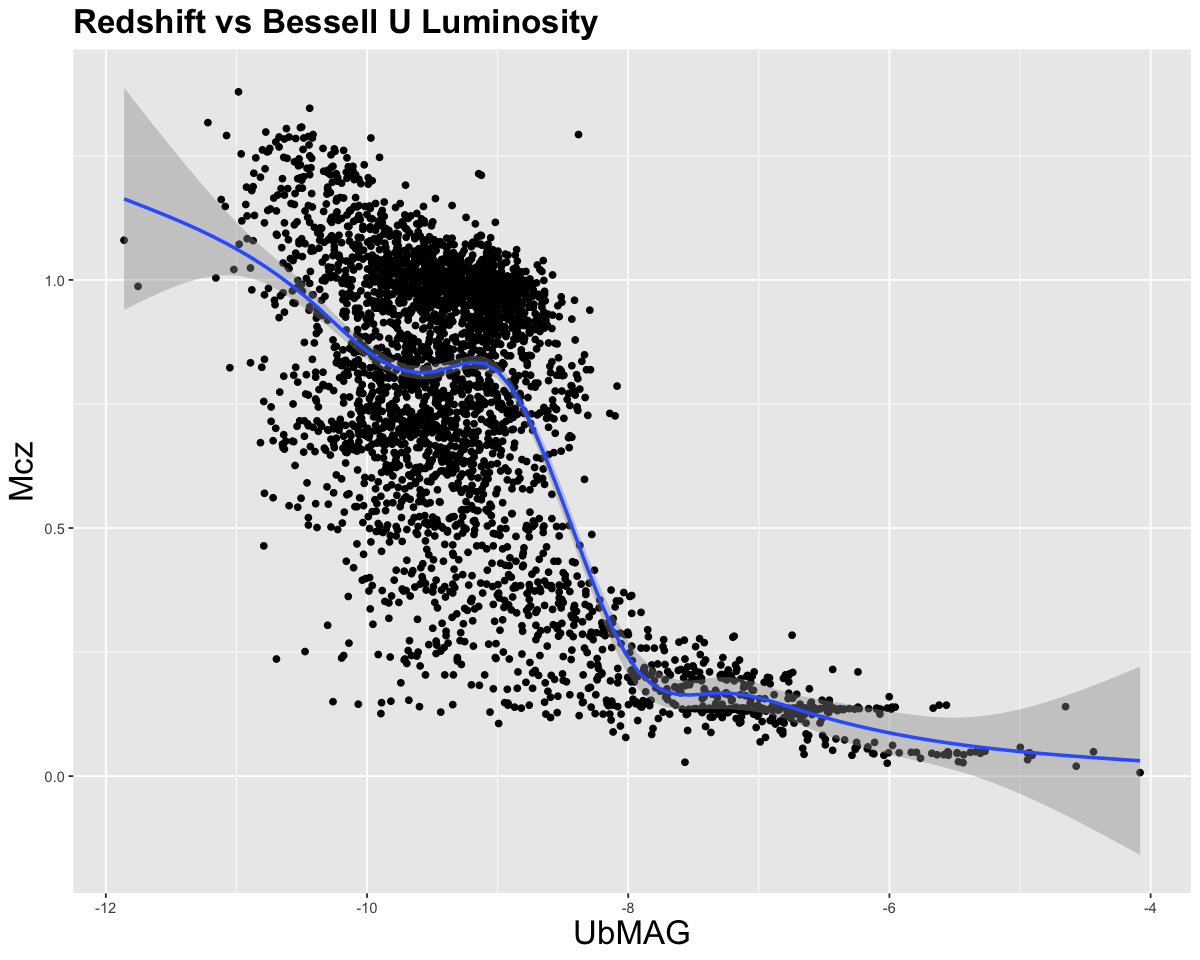

In [9]:
#plot(c17$UbMAG, c17$Mcz, xlab="Bessell U luminosity", ylab="Redshift Magnitude")
options(repr.plot.width=10, repr.plot.height=8)
ggplot(c17, aes(x = UbMAG, y = Mcz)) +
  geom_point() + geom_smooth() +
  theme(
      plot.title = element_text(size=20, face = "bold"),
      axis.title.y = element_text(size = rel(1.8), angle = 90),
      axis.title.x = element_text(size = rel(1.8))) +
  ggtitle("Redshift vs Bessell U Luminosity")
